#Mobiles Dataset (2025) Random Foreest

##Set up

In [ ]:
use_grid_search = False
use_feature_selection = False

In [ ]:
# choice = ''
# while choice not in ['1', '2']:
#   print('1. Use Grid Search')
#   print('2. Use Default Parameters')
#   choice = input('Enter your choice:')

# if choice == '1':
#   use_grid_search = True
# else:
#   use_grid_search = False


# choice = ''
# while choice not in ['1', '2']:
#   print('1. Use Feature Selection')
#   print('2. Do not use Feature Selection')
#   choice = input('Enter your choice:')

# if choice == '1':
#   use_feature_selection = True
# else:
#   use_feature_selection = False

##Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

##Importing Dataset

In [ ]:
data = pd.read_csv("Mobiles Dataset (2025).csv", encoding = "latin-1")

data.head()

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year
0,Apple,iPhone 16 128GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 224,999","INR 79,999","CNY 5,799",USD 799,"AED 2,799",2024
1,Apple,iPhone 16 256GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 234,999","INR 84,999","CNY 6,099",USD 849,"AED 2,999",2024
2,Apple,iPhone 16 512GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 244,999","INR 89,999","CNY 6,499",USD 899,"AED 3,199",2024
3,Apple,iPhone 16 Plus 128GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 249,999","INR 89,999","CNY 6,199",USD 899,"AED 3,199",2024
4,Apple,iPhone 16 Plus 256GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 259,999","INR 94,999","CNY 6,499",USD 949,"AED 3,399",2024


In [ ]:
data.columns

Index(['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera',
       'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size',
       'Launched Price (Pakistan)', 'Launched Price (India)',
       'Launched Price (China)', 'Launched Price (USA)',
       'Launched Price (Dubai)', 'Launched Year'],
      dtype='object')

In [ ]:
data.shape

(930, 15)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Name               930 non-null    object
 1   Model Name                 930 non-null    object
 2   Mobile Weight              930 non-null    object
 3   RAM                        930 non-null    object
 4   Front Camera               930 non-null    object
 5   Back Camera                930 non-null    object
 6   Processor                  930 non-null    object
 7   Battery Capacity           930 non-null    object
 8   Screen Size                930 non-null    object
 9   Launched Price (Pakistan)  930 non-null    object
 10  Launched Price (India)     930 non-null    object
 11  Launched Price (China)     930 non-null    object
 12  Launched Price (USA)       930 non-null    object
 13  Launched Price (Dubai)     930 non-null    object
 14  Launched Y

In [ ]:
data.describe()

,Launched Year
count,930.000000
mean,2022.193548
std,1.862080
min,2014.000000
25%,2021.000000
50%,2023.000000
75%,2024.000000
max,2025.000000


In [ ]:
for col in data.columns:
  print(data[col].value_counts())
  print()

Company Name
Oppo        129
Apple        97
Honor        91
Samsung      88
Vivo         86
Realme       69
Motorola     62
Infinix      56
OnePlus      53
Huawei       42
Tecno        39
POCO         30
Xiaomi       27
Google       21
Lenovo       15
Nokia        11
Sony          9
iQOO          3
Poco          2
Name: count, dtype: int64

Model Name
Pad 128GB        3
Pad 2 256GB      3
K10x 128GB       2
K10x 256GB       2
K10 5G 128GB     2
                ..
V25 Pro 128GB    1
V25 Pro 256GB    1
X90 Pro 256GB    1
X90 Pro 512GB    1
X70 Pro 128GB    1
Name: count, Length: 908, dtype: int64

Mobile Weight
190g      68
195g      64
185g      29
192g      26
180g      25
          ..
288g       1
495g       1
505g       1
475g       1
178.8g     1
Name: count, Length: 148, dtype: int64

RAM
8GB           308
6GB           206
12GB          193
4GB           146
3GB            34
16GB           31
2GB             6
1.5GB           2
8GB / 12GB      2
10GB            1
1GB            

Looking for null values

In [ ]:
data.isnull().sum()

,0
Company Name,0
Model Name,0
Mobile Weight,0
RAM,0
Front Camera,0
Back Camera,0
Processor,0
Battery Capacity,0
Screen Size,0
Launched Price (Pakistan),0


Hence no nulls

Looking for duplicates

In [ ]:
data.duplicated().sum()

np.int64(15)

Inspecting unique values

In [ ]:
temp = ['Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Battery Capacity', 'Screen Size']

for col in temp:
    print(f"Unique values for column ", col, ":")
    print(data[col].unique())
    print()


Unique values for column  Mobile Weight :
['174g' '203g' '206g' '221g' '171g' '172g' '140g' '204g' '238g' '135g'
 '164g' '189g' '228g' '194g' '188g' '226g' '177g' '208g' '458g' '490g'
 '300.5g' '468g' '682g' '708g' '234g' '196g' '168g' '195g' '167g' '254g'
 '187g' '263g' '199g' '190g' '202g' '198g' '192g' '235g' '191g' '181g'
 '178g' '175g' '165g' '143g' '229g' '732g' '586g' '498g' '523g' '726g'
 '567g' '503g' '480g' '366g' '508g' '433g' '674g' '426g' '360g' '205g'
 '179g' '200g' '183g' '185g' '180g' '173g' '184g' '170g' '162g' '210g'
 '155g' '215g' '550g' '610g' '223g' '150g' '146g' '158g' '163g' '153g'
 '176g' '201g' '193g' '159g' '156g' '182g' '535g' '510g' '500g' '560g'
 '520g' '540g' '555g' '239g' '186g' '533g' '218g' '207g' '233g' '222.8g'
 '440g' '482g' '466g' '499g' '372g' '465g' '209g' '166g' '169g' '295g'
 '255g' '197g' '225g' '220g' '241g' '245g' '161g' '580g' '147g' '151g'
 '212g' '213g' '216g' '222g' '250g' '450g' '420g' '280g' '230g' '240g'
 '470g' '211g' '227g' '236g' '2

##Cleaning


In [ ]:
cleaned = data.copy()

###Handling duplicates

In [ ]:
cleaned.duplicated().sum()

np.int64(15)

In [ ]:
cleaned.drop_duplicates(inplace=True)

In [ ]:
cleaned.duplicated().sum()

np.int64(0)

###Converting battery to int

In [ ]:
cleaned['Battery Capacity'] = cleaned['Battery Capacity'].str.replace('mAh', '').str.replace(',', '').astype(int)

###Converting RAM to float

Replace '8GB / 12GB' with '8GB', since this is the base configuration

In [ ]:
cleaned['RAM'] = cleaned['RAM'].replace('8GB / 12GB', '8GB')

In [ ]:
cleaned['RAM'] = cleaned['RAM'].str.replace('GB', '').astype(float)  # Remove 'GB' and convert to float

###Converting Weight

In [ ]:
cleaned['Mobile Weight'] = cleaned['Mobile Weight'].str.replace('g', '').astype(float)

###Convert size

Setting the size to the maximum size for the foldable devices

In [ ]:
cleaned['Screen Size'] = cleaned['Screen Size'].replace('6.7 inches (main), 2.7 inches (external)', '6.7 inches')
cleaned['Screen Size'] = cleaned['Screen Size'].replace('6.9 inches (internal), 4.0 inches (external)', '6.9 inches')
cleaned['Screen Size'] = cleaned['Screen Size'].replace( '6.7 inches (internal), 3.6 inches (external)', '6.7 inches')

Looking at unique screen size values

In [ ]:
col = 'Screen Size'
print(f"Unique values for column ", col, ":")
print(cleaned[col].unique())

Unique values for column  Screen Size :
['6.1 inches' '6.7 inches' '5.4 inches' '5.8 inches' '6.5 inches'
 '10.9 inches' '10.2 inches' '7.9 inches' '11 inches' '12.9 inches'
 '13 inches' '6.8 inches' '6.6 inches' '7.6 inches' '6.4 inches'
 '6.9 inches' '6.3 inches' '5.3 inches' '6.0 inches' '5.5 inches'
 '5.7 inches' '5.2 inches' '14.6 inches' '12.4 inches' '8.7 inches'
 '10.5 inches' '8 inches' '10.1 inches' '6.74 inches' '6.72 inches'
 '7.8 inches' '6.55 inches' '6.43 inches' '6.49 inches' '6.52 inches'
 '6.78 inches' '6.59 inches' '6.44 inches' '6.41 inches' '6.01 inches'
 '6.67 inches' '6.28 inches' '11.61 inches' '6.31 inches' '6.58 inches'
 '6.38 inches' '6.56 inches' '5.88 inches' '6.22 inches' '5.0 inches'
 '6.51 inches' '6.35 inches' '6.53 inches' '6.39 inches' '6.47 inches'
 '10.4 inches' '12.3 inches' '7.82 inches' '6.83 inches' '11.6 inches'
 '12.1 inches' '6.82 inches' '7.1 inches' '11.5 inches' '6.73 inches'
 '6.36 inches' '6.09 inches' '6.9 inches (unfolded)'
 '8.0 inche

Checking on rows with '(unfolded)' to determine if they would be an issue

In [ ]:
cleaned[cleaned['Screen Size'].str.contains('unfolded', case=False, na=False)]

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year
628,Huawei,P50 Pocket,190.0,8.0,10.7MP,40MP,Snapdragon 888 4G,4000,6.9 inches (unfolded),"PKR 199,999","INR 129,999","CNY 8,988","USD 1,299","AED 4,799",2021
630,Huawei,Mate X2,295.0,8.0,16MP,50MP,Kirin 9000 5G,4500,8.0 inches (unfolded),"PKR 349,999","INR 249,999","CNY 17,999","USD 2,699","AED 9,999",2021
634,Huawei,Mate Xs 2,255.0,8.0,10.7MP,50MP,Snapdragon 888 4G,4600,7.8 inches (unfolded),"PKR 299,999","INR 199,999","CNY 14,999","USD 2,499","AED 8,999",2022
643,Huawei,Mate X3,239.0,12.0,8MP,50MP (wide) + 13MP (ultrawide) + 12MP (perisco...,Snapdragon 8+ Gen 1 4G,4800,7.85 inches (unfolded),"PKR 349,999","INR 249,999","CNY 13,999","USD 2,499","AED 9,999",2023


Converting size to float

In [ ]:
cleaned['Screen Size'] = cleaned['Screen Size'].str.extract(r'(\d+\.?\d*)').astype(float)

Checking that unfolded is properly done

In [ ]:
cleaned[cleaned.index==628]

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year
628,Huawei,P50 Pocket,190.0,8.0,10.7MP,40MP,Snapdragon 888 4G,4000,6.9,"PKR 199,999","INR 129,999","CNY 8,988","USD 1,299","AED 4,799",2021


###Converting Back Camera

Normalizing specific values

In [ ]:
cleaned['Back Camera'] = cleaned['Back Camera'].replace('13MP (f/1.8, AF)', '13 MP')

Checking if any value is separated by a comma

In [ ]:
cleaned[cleaned['Back Camera'].str.contains(',', na=False)]

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year


Splitting up back camera into differnt columns depending on the number of cameras, indicated by +

In [ ]:
split_columns = cleaned['Back Camera'].str.split('+', expand=True)
split_columns.columns = [f'Back Camera {i+1}' for i in range(split_columns.shape[1])]
# Merging into cleaned
cleaned = pd.concat([cleaned, split_columns], axis=1)

In [ ]:
cleaned.drop(columns=['Back Camera'], inplace=True)

Converting Back Cameras into int and replacing nulls with 0

In [ ]:
columns_to_convert = ['Back Camera 1', 'Back Camera 2', 'Back Camera 3', 'Back Camera 4']
for col in columns_to_convert:
    cleaned[col] = cleaned[col].str.extract('(\d+)').astype(float).fillna(0).astype(int)

###Converting Front Camera

Fixing specific values

In [ ]:
cleaned['Front Camera'] = cleaned['Front Camera'].replace('10MP, 4MP (UDC)', '10 MP + 4 MP')
cleaned['Front Camera'] = cleaned['Front Camera'].replace('12MP / 4K', '12 MP')

Checking for commas

In [ ]:
cleaned[cleaned['Front Camera'].str.contains(',', na=False)]

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year,Back Camera 1,Back Camera 2,Back Camera 3,Back Camera 4


Splitting up back camera into differnt columns depending on the number of cameras, indicated by +

In [ ]:
split_columns = cleaned['Front Camera'].str.split('+', expand=True)
split_columns.columns = [f'Front Camera {i+1}' for i in range(split_columns.shape[1])]
# Merging into cleaned
cleaned = pd.concat([cleaned, split_columns], axis=1)

In [ ]:
cleaned.drop(columns=['Front Camera'], inplace=True)

Converting to int and filling nulls with 0

In [ ]:
cleaned['Front Camera 1'] = cleaned['Front Camera 1'].str.extract('(\d+)').astype(float).fillna(0).astype(int)
cleaned['Front Camera 2'] = cleaned['Front Camera 2'].str.extract('(\d+)').astype(float).fillna(0).astype(int)

###Extracting Storage from Model Name

Checking the units used

Removing records of models that do not contain TB or GB

In [ ]:
temp = cleaned[~cleaned['Model Name'].str.contains('TB|GB', na=False)]
temp['Model Name'].unique()

array(['OnePlus Pad', 'OnePlus Pad 2', 'OnePlus Pad Pro', 'P50',
       'P50 Pro', 'P50 Pocket', 'Mate 40E', 'Mate X2', 'Nova 9',
       'Nova 9 Pro', 'P50E', 'Mate Xs 2', 'Mate 50', 'Mate 50 Pro',
       'Nova 10', 'Nova 10 Pro', 'Nova 10 SE', 'P60', 'P60 Pro',
       'P60 Art', 'Mate X3', 'Mate 60', 'Mate 60 Pro', 'Mate 60 Pro+',
       'Nova 11', 'Nova 11 Pro', 'Nova 11 Ultra', 'Pura 70',
       'Pura 70 Pro', 'Pura 70 Pro+', 'Pura 70 Ultra', 'Mate 70',
       'Mate 70 Pro', 'Mate 70 Pro+', 'Mate X6', 'Nova 12', 'Nova 12 Pro',
       'T21', 'Xpad', 'Xpad 5G', 'Xpad Lite', 'Xpad Pro', 'Hot 50',
       'Hot 50i', 'Hot 50 5G', 'Hot 50 Pro', 'Hot 50 Pro+', 'GT 20 Pro',
       'Note 40X 5G', 'Note 40S', 'Note 40 5G', 'Note 40 Pro 5G',
       'Note 40 Racing Edition', 'Hot 40', 'Hot 40i', 'Hot 40 Pro',
       'Zero 40', 'Zero 40 5G', 'Zero Flip', 'Note 40', 'Note 40 Pro',
       '9X Lite', '30', '30 Pro', '30 Pro+', '30S', 'X10', 'X10 Max',
       'Play 4', 'Play 4 Pro', '10X Lite', 'V40'

In [ ]:
cleaned = cleaned[cleaned['Model Name'].str.contains('GB|TB', na=False)]

In [ ]:
cleaned[['Model Name', 'Storage']] = cleaned['Model Name'].str.extract(r'(.+)\s(\d+(?:GB|TB))')

<ipython-input-38-9a14765a1172>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned[['Model Name', 'Storage']] = cleaned['Model Name'].str.extract(r'(.+)\s(\d+(?:GB|TB))')
<ipython-input-38-9a14765a1172>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned[['Model Name', 'Storage']] = cleaned['Model Name'].str.extract(r'(.+)\s(\d+(?:GB|TB))')


Checking for nulls and duplicates

In [ ]:
cleaned.isnull().sum()

,0
Company Name,0
Model Name,0
Mobile Weight,0
RAM,0
Processor,0
Battery Capacity,0
Screen Size,0
Launched Price (Pakistan),0
Launched Price (India),0
Launched Price (China),0


In [ ]:
cleaned.duplicated().sum()

np.int64(0)

Converting storage to int in terms of GB

In [ ]:
cleaned['Storage'] = cleaned['Storage'].str.replace('TB', '*1024').str.replace('GB', '').map(eval).astype(str) + 'GB'

<ipython-input-41-2ed1c785e7bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['Storage'] = cleaned['Storage'].str.replace('TB', '*1024').str.replace('GB', '').map(eval).astype(str) + 'GB'


In [ ]:
cleaned['Storage'] = cleaned['Storage'].str.extract('(\d+)').astype(int)

<ipython-input-42-8cd537ae9052>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['Storage'] = cleaned['Storage'].str.extract('(\d+)').astype(int)


###Converting Prices in floats

In [ ]:
price_columns = [
    "Launched Price (Pakistan)",
    "Launched Price (India)",
    "Launched Price (China)",
    "Launched Price (USA)",
    "Launched Price (Dubai)"
]

Removing everything except digits and '.' from price columns

In [ ]:
for col in price_columns:
    cleaned[col] = cleaned[col].str.replace(r"[^\d.]", "", regex=True)

<ipython-input-44-f08fbc7a1a30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned[col] = cleaned[col].str.replace(r"[^\d.]", "", regex=True)


Converting prices to floats

In [ ]:
for col in price_columns:
    cleaned[col] = pd.to_numeric(cleaned[col], errors='coerce')

In [ ]:
cleaned.isnull().sum()

,0
Company Name,0
Model Name,0
Mobile Weight,0
RAM,0
Processor,0
Battery Capacity,0
Screen Size,0
Launched Price (Pakistan),1
Launched Price (India),0
Launched Price (China),0


Inspecting null value

In [ ]:
cleaned[cleaned.isnull().any(axis=1)]

,Company Name,Model Name,Mobile Weight,RAM,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year,Back Camera 1,Back Camera 2,Back Camera 3,Back Camera 4,Front Camera 1,Front Camera 2,Storage
929,Samsung,Galaxy Z Fold6,239.0,12.0,Snapdragon 8 Gen 3,4400,7.6,NaN,200999,17999,2259.0,8699,2024,50,0,0,0,10,4,1024


In [ ]:
data[data.index==929]

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year
929,Samsung,Galaxy Z Fold6 1TB,239g,12GB,"10MP, 4MP (UDC)",50MP,Snapdragon 8 Gen 3,4400mAh,7.6 inches,Not available,"INR 200,999","CNY 17,999","USD 2,259","AED 8,699",2024


Since the value here is not available from the original dataset, we convert to Pakistan using the average conversion rate in 2024 from USD

In [ ]:
cleaned['Launched Price (Pakistan)'] = cleaned['Launched Price (Pakistan)'].fillna(630508.08)

In [ ]:
cleaned[cleaned.index==929]

,Company Name,Model Name,Mobile Weight,RAM,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year,Back Camera 1,Back Camera 2,Back Camera 3,Back Camera 4,Front Camera 1,Front Camera 2,Storage
929,Samsung,Galaxy Z Fold6,239.0,12.0,Snapdragon 8 Gen 3,4400,7.6,630508.08,200999,17999,2259.0,8699,2024,50,0,0,0,10,4,1024


###Inspecting Cleaned dataframe

In [ ]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 763 entries, 0 to 929
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Company Name               763 non-null    object 
 1   Model Name                 763 non-null    object 
 2   Mobile Weight              763 non-null    float64
 3   RAM                        763 non-null    float64
 4   Processor                  763 non-null    object 
 5   Battery Capacity           763 non-null    int64  
 6   Screen Size                763 non-null    float64
 7   Launched Price (Pakistan)  763 non-null    float64
 8   Launched Price (India)     763 non-null    int64  
 9   Launched Price (China)     763 non-null    int64  
 10  Launched Price (USA)       763 non-null    float64
 11  Launched Price (Dubai)     763 non-null    int64  
 12  Launched Year              763 non-null    int64  
 13  Back Camera 1              763 non-null    int64  
 14 

In [ ]:
for col in cleaned.columns:
  if cleaned.dtypes[col] == 'object':
    print(col)

Company Name
Model Name
Processor


In [ ]:
cleaned.describe()

,Mobile Weight,RAM,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year,Back Camera 1,Back Camera 2,Back Camera 3,Back Camera 4,Front Camera 1,Front Camera 2,Storage
count,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000
mean,221.309830,7.651376,4955.618611,6.956225,127703.508624,50001.473132,3829.707733,572.429436,2141.993447,2022.132372,45.283093,6.643512,2.694626,0.047182,18.077326,0.089122,213.619921
std,99.156102,3.222046,1311.545769,1.412366,106236.084151,39558.061192,2719.527314,400.432143,1488.515425,1.952732,29.807802,12.074302,10.082068,0.303742,11.338761,0.876898,156.355196
min,135.000000,1.000000,2000.000000,5.000000,15999.000000,5999.000000,499.000000,79.000000,299.000000,2014.000000,5.000000,0.000000,0.000000,0.000000,2.000000,0.000000,16.000000
25%,184.000000,6.000000,4400.000000,6.500000,51499.500000,19999.000000,1699.500000,249.000000,999.000000,2021.000000,13.000000,0.000000,0.000000,0.000000,8.000000,0.000000,128.000000
50%,193.000000,8.000000,5000.000000,6.600000,84999.000000,34999.000000,2900.000000,449.000000,1620.000000,2023.000000,50.000000,2.000000,0.000000,0.000000,16.000000,0.000000,128.000000
75%,206.000000,8.000000,5000.000000,6.740000,179999.000000,74949.500000,5649.000000,849.000000,3199.000000,2024.000000,50.000000,8.000000,0.000000,0.000000,32.000000,0.000000,256.000000
max,732.000000,16.000000,11200.000000,14.600000,630508.080000,274999.000000,17999.000000,2799.000000,11099.000000,2025.000000,200.000000,64.000000,64.000000,2.000000,60.000000,12.000000,2048.000000


In [ ]:
cleaned.head()

,Company Name,Model Name,Mobile Weight,RAM,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year,Back Camera 1,Back Camera 2,Back Camera 3,Back Camera 4,Front Camera 1,Front Camera 2,Storage
0,Apple,iPhone 16,174.0,6.0,A17 Bionic,3600,6.1,224999.0,79999,5799,799.0,2799,2024,48,0,0,0,12,0,128
1,Apple,iPhone 16,174.0,6.0,A17 Bionic,3600,6.1,234999.0,84999,6099,849.0,2999,2024,48,0,0,0,12,0,256
2,Apple,iPhone 16,174.0,6.0,A17 Bionic,3600,6.1,244999.0,89999,6499,899.0,3199,2024,48,0,0,0,12,0,512
3,Apple,iPhone 16 Plus,203.0,6.0,A17 Bionic,4200,6.7,249999.0,89999,6199,899.0,3199,2024,48,0,0,0,12,0,128
4,Apple,iPhone 16 Plus,203.0,6.0,A17 Bionic,4200,6.7,259999.0,94999,6499,949.0,3399,2024,48,0,0,0,12,0,256


In [ ]:
cleaned.isnull().sum()

,0
Company Name,0
Model Name,0
Mobile Weight,0
RAM,0
Processor,0
Battery Capacity,0
Screen Size,0
Launched Price (Pakistan),0
Launched Price (India),0
Launched Price (China),0


In [ ]:
cleaned.duplicated().sum()

np.int64(0)

###Anomally handling

Helper function to polt the box plots

In [ ]:
cleaned['price'] = cleaned['Launched Price (USA)']

In [ ]:
Q3 = cleaned['price'].quantile(0.75)
Q1 = cleaned['price'].quantile(0.25)
IQR = Q3 - Q1
print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)

Q1: 249.0
Q3: 849.0
IQR: 600.0


In [ ]:
print(Q3 + 1.5 * IQR)
cleaned[cleaned['price'] > (Q3 + 1.5 * IQR)].shape #Number of outliers above

1749.0


(12, 21)

In [ ]:
print(Q1 - 1.5 * IQR)
cleaned[cleaned['price'] < (Q1 - 1.5 * IQR)].shape #Number of outliers below

-651.0


(0, 21)

In [ ]:
def box_plot(df, x, y):
  plt.figure(figsize=(14,6))
  sns.boxplot(x=df[x], y=df[y])
  plt.xticks(rotation='vertical')
  plt.show()

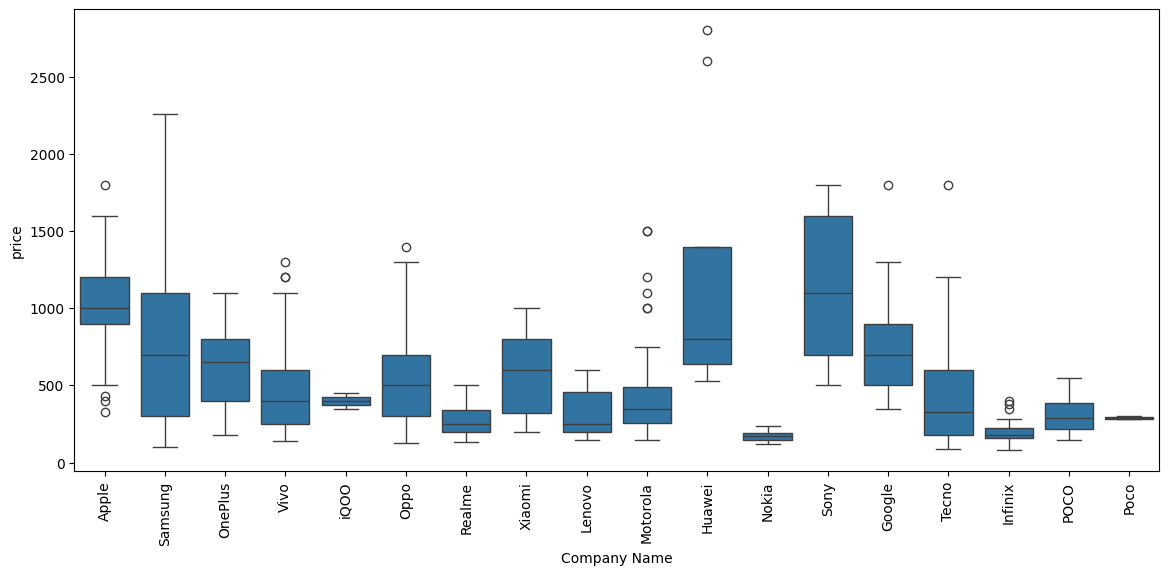

In [ ]:
box_plot(cleaned, 'Company Name', 'price')

In [ ]:
# cleaned.drop(cleaned[cleaned['price'] > 1400].index, inplace=True)

In [ ]:
cleaned.drop(cleaned[cleaned['price'] > (Q3 + 1.5 * IQR)].index, inplace=True)
cleaned.drop(cleaned[cleaned['price'] < (Q1 - 1.5 * IQR)].index, inplace=True)

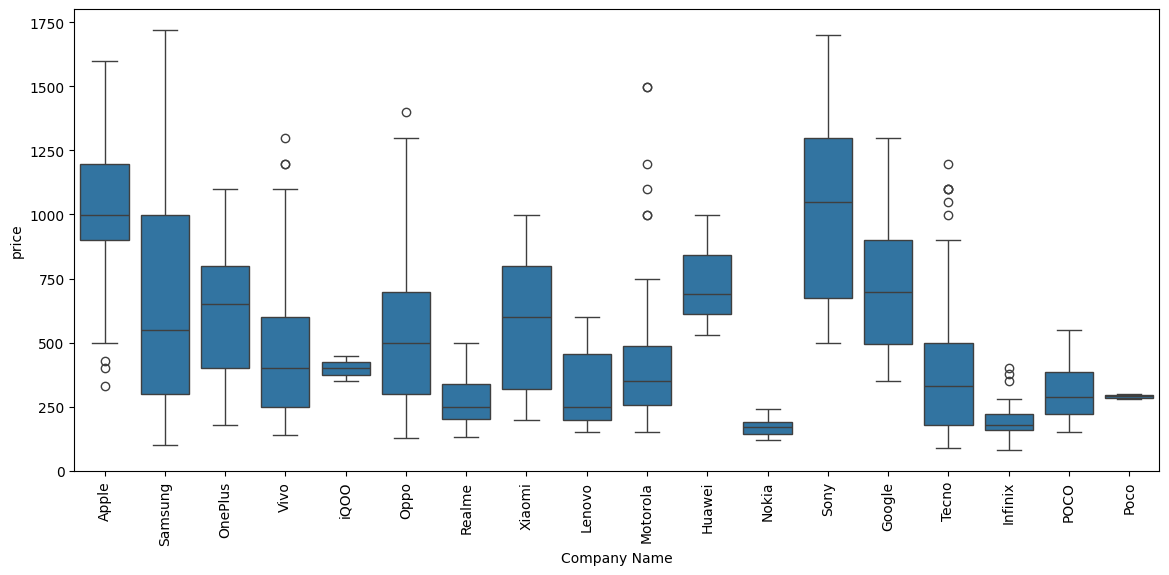

In [ ]:
box_plot(cleaned, 'Company Name', 'price')

##Preparing data for modelling

###Dropping columns

In [ ]:
cleaned.drop(['Model Name', 'Launched Price (Pakistan)', 'Launched Price (India)', 'Launched Price (China)', 'Launched Price (Dubai)', 'Launched Price (USA)'], axis=1, inplace=True)

In [ ]:
cleaned.columns

Index(['Company Name', 'Mobile Weight', 'RAM', 'Processor', 'Battery Capacity',
       'Screen Size', 'Launched Year', 'Back Camera 1', 'Back Camera 2',
       'Back Camera 3', 'Back Camera 4', 'Front Camera 1', 'Front Camera 2',
       'Storage', 'price'],
      dtype='object')

###Scaling Numerical Data

In [ ]:
for col in cleaned.columns:
  if cleaned.dtypes[col] == 'object':
    continue
  if col == 'price':
    price_scaler = StandardScaler()
    cleaned[col] = price_scaler.fit_transform(cleaned[col].values.reshape(-1,1))
    continue
  scaler = StandardScaler()
  cleaned[col] = scaler.fit_transform(cleaned[col].values.reshape(-1,1))

In [ ]:
cleaned.head()

,Company Name,Mobile Weight,RAM,Processor,Battery Capacity,Screen Size,Launched Year,Back Camera 1,Back Camera 2,Back Camera 3,Back Camera 4,Front Camera 1,Front Camera 2,Storage,price
0,Apple,-0.471285,-0.496607,A17 Bionic,-1.035207,-0.598180,0.962994,0.091958,-0.54698,-0.26422,-0.156706,-0.542658,-0.092919,-0.582036,0.699624
1,Apple,-0.471285,-0.496607,A17 Bionic,-1.035207,-0.598180,0.962994,0.091958,-0.54698,-0.26422,-0.156706,-0.542658,-0.092919,0.351210,0.839785
2,Apple,-0.471285,-0.496607,A17 Bionic,-1.035207,-0.598180,0.962994,0.091958,-0.54698,-0.26422,-0.156706,-0.542658,-0.092919,2.217700,0.979946
3,Apple,-0.175961,-0.496607,A17 Bionic,-0.575559,-0.170413,0.962994,0.091958,-0.54698,-0.26422,-0.156706,-0.542658,-0.092919,-0.582036,0.979946
4,Apple,-0.175961,-0.496607,A17 Bionic,-0.575559,-0.170413,0.962994,0.091958,-0.54698,-0.26422,-0.156706,-0.542658,-0.092919,0.351210,1.120107


###Encoding Strings

In [ ]:
string_cols = []
for col in cleaned.columns:
  if cleaned.dtypes[col] == 'object':
    string_cols.append(col)
    print(col)

Company Name
Processor


In [ ]:
for col in string_cols:
    encoder = TargetEncoder(target_type="continuous", random_state=42, smooth = 5)
    X = cleaned[col].values.reshape(-1, 1)
    encoder.fit(X, cleaned['price'])
    cleaned[col] = encoder.transform(X)

In [ ]:
cleaned.columns

Index(['Company Name', 'Mobile Weight', 'RAM', 'Processor', 'Battery Capacity',
       'Screen Size', 'Launched Year', 'Back Camera 1', 'Back Camera 2',
       'Back Camera 3', 'Back Camera 4', 'Front Camera 1', 'Front Camera 2',
       'Storage', 'price'],
      dtype='object')

##Building Model

###Loading X and y

In [ ]:
X = cleaned.drop('price', axis=1)
y = cleaned['price']

In [ ]:
print(X.shape)
print(y.shape)

(751, 14)
(751,)


###Feature Selection

In [ ]:
sfm = SelectFromModel(RandomForestRegressor())
sfm.fit(X, y)

X_new = sfm.transform(X)

Looking at features ranked and the ones selected.

In [ ]:
importances = sfm.estimator_.feature_importances_
feature_scores = pd.DataFrame({
    'Feature': X.columns,
      'Importance': importances
}).sort_values(by='Importance', ascending = False),

print(feature_scores)

# Get the indices of the selected features
selected_feature_indices = sfm.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

for col in X.columns:
  if col not in selected_feature_names:
    print("Unselected Features:", col)

(             Feature  Importance
3          Processor    0.776533
1      Mobile Weight    0.036753
0       Company Name    0.034481
13           Storage    0.030809
2                RAM    0.025092
11    Front Camera 1    0.021753
7      Back Camera 1    0.020077
5        Screen Size    0.018446
4   Battery Capacity    0.014889
8      Back Camera 2    0.013729
6      Launched Year    0.004186
9      Back Camera 3    0.002016
12    Front Camera 2    0.001102
10     Back Camera 4    0.000135,)
Unselected Features: Company Name
Unselected Features: Mobile Weight
Unselected Features: RAM
Unselected Features: Battery Capacity
Unselected Features: Screen Size
Unselected Features: Launched Year
Unselected Features: Back Camera 1
Unselected Features: Back Camera 2
Unselected Features: Back Camera 3
Unselected Features: Back Camera 4
Unselected Features: Front Camera 1
Unselected Features: Front Camera 2
Unselected Features: Storage


In [ ]:
if use_feature_selection:
  X = X_new

###Splitting up training and testing data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(600, 14)
(151, 14)
(600,)
(151,)


###Finding best parameters

In [ ]:
if use_grid_search:
  param_grid = {
      'max_depth': [50, 100, 150, 200],
      'max_features': ['sqrt', 'log2'],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'bootstrap': [False],
      'max_leaf_nodes': [50, 100, 150, 200],
      'n_estimators': [100, 150, 200, 250],
      'random_state': [42]
  }

In [ ]:
if use_grid_search:
  grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, scoring='neg_mean_absolute_error', n_jobs=3, cv = 3, error_score='raise')


In [ ]:
if use_grid_search:
  grid_search.fit(X_train, y_train)

In [ ]:
if use_grid_search:
  print(grid_search.best_params_)

###Building Random Forest Model

In [ ]:
if use_grid_search:
  model = RandomForestRegressor(**grid_search.best_params_)
else:
  # model = RandomForestRegressor(max_depth = 50, max_features =  'sqrt', min_samples_leaf = 1, min_samples_split = 2, bootstrap= False, max_leaf_nodes=200, n_estimators = 150, random_state = 42)
  # model = RandomForestRegressor(max_depth = 100, max_features =  'sqrt', min_samples_leaf = 4, min_samples_split = 2, bootstrap= True, max_leaf_nodes=150, n_estimators = 250, random_state = 42)
  # model = RandomForestRegressor(max_depth = 50, max_features =  'sqrt', min_samples_leaf = 1, min_samples_split = 2, bootstrap= False, max_leaf_nodes=200, n_estimators = 150, random_state = 42)
  params = {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': 200, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 42}
  model = RandomForestRegressor(**params)

model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      max_leaf_nodes=200, n_estimators=150, random_state=42)

##Testing Model

In [ ]:
print(f'Train Accuracy: {model.score(X_train, y_train):.3f}')
print(f'Test Accuracy:  {model.score(X_test, y_test):.3f}')

Train Accuracy: 0.996
Test Accuracy:  0.955


In [ ]:
# Making predictions on the test set
y_pred = model.predict(X_test)

y_pred = price_scaler.inverse_transform(y_pred.reshape(-1,1))
y_test = price_scaler.inverse_transform(y_test.values.reshape(-1,1))

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_pred):.2f}')

Mean Absolute Error: 52.44
Mean Absolute Percentage Error: 0.12


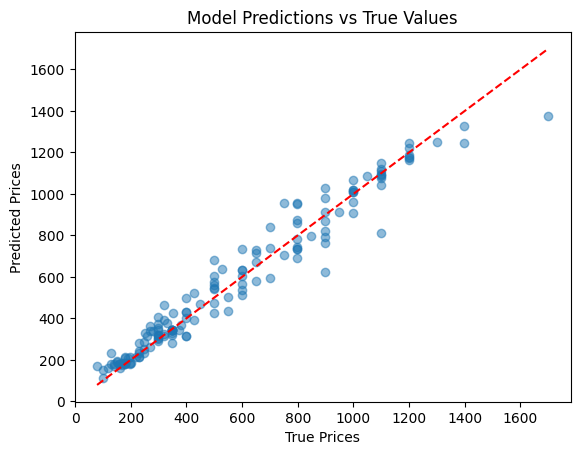

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Model Predictions vs True Values")
plt.show()